# Metric Methods

### Setting:
1. Task: For subjects labeled $\{S_1, \ldots, S_n\}$ we are given $T_i$ trials of EEG brain scans. Each trial is a matrix in $\mathbb{R^{C \times T}}$ where $C$ is the number of eeg channels and $T$ is the number of timesteps. For this specific case, $C = 100$ and $T \in [100 000, 200 000]$

2. Comparison: We would like to make a calculation of discriminibility using various metrics. The discriminibility parameters are as follows:
    * D -- Data Set -- List of data matrices d for each trial for each subject.
    * R -- Data Representation -- Dependent on the metric used, e.g. if the metric is the distance between correlation matricies, R will be the correlation matricies of the various data points in D.
    * L -- Labels -- The label of the subject.
    * $\Delta$ -- Metric -- We will use various metrics and compare the results.

3. Statistical goals:
  * Our goal is to find a metric (metrics) with which we will calculate the discriminibility in future experiments. This metric should have the following properties:
    * Metric does not already produce trivially optimal discriminibility
      * e.g. if we recieve a discriminibility of 1 on the raw data for this, there is nothing to maximize
    * Metric does not seem to be producing random output
      * e.g. if the discriminibility is around .5 for a 2 subject experiment, we might expect that this metric is not good and will remain random throughout.
      
4. Desirata
    * Metric is fast to compute
      * We will need to run this metric many times if we will be using it to calculate discriminibility in some sort of parameter maximization technique.
    * Metric is simple
      * A metric which performs well on this certain task may not generalize well to other data sets if it is extremely complicated.

### Approach
We will list here many candidate metrics, along with some reasoning for chosing them.

* Frobenius Norm
  * Formal: $\delta(X, Y) = \vert\vert X - Y \vert\vert_{F} = \sqrt{\sum_{i, j}(X_{ij} - Y_{ij})^2}, X, Y \in \mathbb{R}^{C \times T}$ the original data matrix.
  * Why: If two scans are aligned to some task (e.g. subjects in each scan start watching same movie at same time), this metric may be able to measure similarity in changes in brain activity.
  * Code: `frob_norm` function below.
  
* Frobenius Norm of Correlation Matricies
  * Formal: $\delta(X, Y) = \vert\vert X - Y \vert\vert_{F} = \sqrt{\sum_{i, j}(X_{ij} - Y_{ij})^2}, X, Y \in \mathbb{R}^{C \times C}$ the correlation matricies.
  * Why: In a resting state scan, the resting functional connectome for one subject will likely be more similar to that of another resting state scan from the same subject than one from a different subject. 
  * Code: `frob_corr` function below.

* Number of 3 cycles of the k-thresholded correlation matrix.
  * Formal: $\delta_k(X, Y) = \vert trace((X > k)^3) - trace((Y > k)^3) \vert$, where $X, Y \in \mathbb{C \times C}$ are correlation matricies.
  * Why: Cyclical structures in a graph can give a notion of connectivity, as they form redundant connections. 3-cycles are very easy and fast to compute, and are also simple structures.
  * Code: `n_3_cycle` function below.
  
* Number of 4 cycles of the k-thresholded correlation matrix.
  * Formal: Let $C_4(A) = trace(A^4) + trace(A^2) -2\sum_{i=1}^n degree_A(v_i)$, then $\delta_k(X, Y) = \vert C_4(X) = C_4(Y)\vert$, where $X, Y \in \mathbb{R}^{C \times C}$ are correlation matricies.
  * Why: For the same reasons as 3 cycles, mostly added because it is also easy to compute and is still quite simple.
  * Code: `n_4_cycle` function below.
  
* Frobenius Norm of Coherence Matrices
  * Formal: $\delta(X, Y) = \vert\vert X - Y \vert\vert_{F}$, where $X, Y \in \mathbb{R}^{C \times C}$ are coherence matricies of the data points.
  * Why: For similar reasons to the correlation matricies, except electrode coherence may be a better measure of connectivity.
  * Code: `frob_coh` function below.
  
For all of the above, perform discriminibility in a leave-one-out manner. E.g, $\sum_{i=1}^n T_n$ times, once for each possible way of leaving out one trial.


### Code for Various Metrics

In [1]:
### GET NEW REPRESENTATIONS

# Return representation of the spectrum
def spect(D):
    return np.linalg.svd(D, full_matrices=False)[1]

# Return identity
def identity(D):
    return D

# Return correlation matrix
def correl(D):
    return np.nan_to_num(np.corrcoef(D))

# Return spectrum of the correlation matrix
def correl_spec(D):
    return np.linalg.svd(np.nan_to_num(np.corrcoef(D)), full_matrices=False)[1]

# Return thresholded correlation matrix
def thresh_correl(D, k):
    return np.nan_to_num(np.corrcoef(D)) > k - np.eye(D.shape[0])

from scipy.signal import coherence as coh
# Return coherence matrix
def coherence(currd):
    coherearr = []
    for i in range (0, len(currd)):
        temparr = []
        for j in range (0, len(currd)):
            temparr.append(np.mean(
                coh(currd[i], currd[j], 500)[1]
            ))
    coherearr.append(temparr)
    return np.array(coherearr)


### METRICS

# Frobenius Norm
def frob(x, y):
    return np.linalg.norm(x-y)

# Diff Num 3 Cycles
def diff_num_3cycle(x, y):
    return np.abs(np.sum(x) - np.sum(y))

# Diff Num 4 Cycles
def diff_num_4cycle(x, y):
    def c4(A):
        return np.trace(np.linalg.matrix_power(A, 4)) + \
               np.trace(np.linalg.matrix_power(A, 2)) - \
               np.sum(np.sum(A, 0)^2)
    return np.abs(c4(x) - c4(y))

### Load Libraries

In [2]:
import h5py
import auto_bench
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
def fast_csv_load(f_path):
    with open(f_path,'r') as dest_f:
        data_iter = csv.reader(dest_f, 
                               delimiter = ',', 
                               quotechar = '"')
        data = [data for data in data_iter]
    data_array = np.asarray(data, dtype = np.float32)  
    return data_array
sns.set_style("darkgrid")

### Load the data

In [3]:
subjects = ['A00054207', 'A00054387', 'A00054930', 'A00055065']
trials = [range(1, 7),
          range(1, 7),
          range(1, 7),
          range(1, 7)]
D = []
L = []
for i, subject in enumerate(subjects):
    for trial in trials[i]:
        L.append(subject)
        f_name = '%s%03d.csv' % (subject, trial)
        print 'Loading', f_name
        f_path = '../data/thicc_folder/' + f_name
        data = fast_csv_load(f_path)[:, 5000:20000]
        D.append(data)

Loading A00054207001.csv
Loading A00054207002.csv
Loading A00054207003.csv
Loading A00054207004.csv
Loading A00054207005.csv
Loading A00054207006.csv
Loading A00054387001.csv
Loading A00054387002.csv
Loading A00054387003.csv
Loading A00054387004.csv
Loading A00054387005.csv
Loading A00054387006.csv
Loading A00054930001.csv
Loading A00054930002.csv
Loading A00054930003.csv
Loading A00054930004.csv
Loading A00054930005.csv
Loading A00054930006.csv
Loading A00055065001.csv
Loading A00055065002.csv
Loading A00055065003.csv
Loading A00055065004.csv
Loading A00055065005.csv
Loading A00055065006.csv


### Mean center all of the trials

In [4]:
D = [d - np.mean(d, axis=1).reshape(-1, 1) for d in D]

### Information about the data set.

In [5]:
fmt = '%14s %14s %10s'
print fmt % ('Label', 'Shape', 'Type')
for i, l in enumerate(L):
    print fmt % (l, D[i].shape, D[i].dtype)

         Label          Shape       Type
     A00054207   (128, 15000)    float32
     A00054207   (128, 15000)    float32
     A00054207   (128, 15000)    float32
     A00054207   (128, 15000)    float32
     A00054207   (128, 15000)    float32
     A00054207   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054387   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00054930   (128, 15000)    float32
     A00055065   (128, 15000)    float32
     A00055065   (128, 15000)    float32
     A00055065   (128, 15000)    float32
     A00055065   (128, 15000)    float32
     A00055065   (128, 15000)    float32
     A00055065  

F
Corr F


/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:2558: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


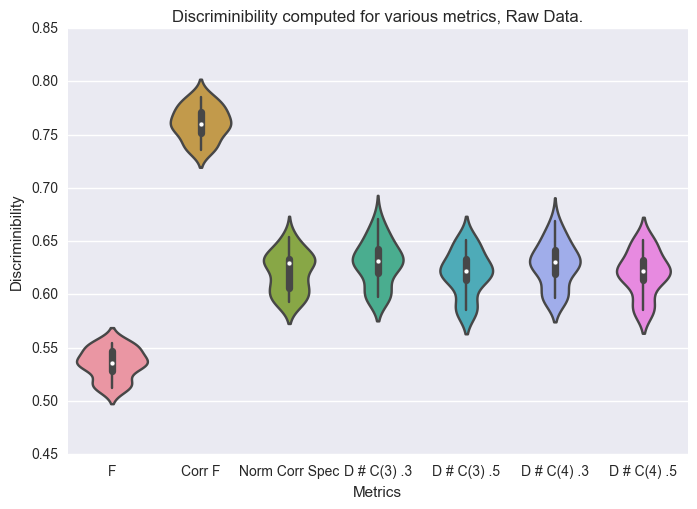

In [6]:
def tc3(D):
    return thresh_correl(D, .3)
def tc5(D):
    return thresh_correl(D, .5)
def tc7(D):
    return thresh_correl(D, .7)

transforms = [identity,
              correl,
              correl_spec,
              tc3,
              tc5,
              tc3,
              tc5]

metrics = [frob,
           frob,
           frob,
           diff_num_3cycle,
           diff_num_3cycle,
           diff_num_4cycle,
           diff_num_4cycle]

names = ['F',
         'Corr F',
         'Norm Corr Spec',
         'D # C(3) .3',
         'D # C(3) .5',
         'D # C(4) .3',
         'D # C(4) .5']

title = 'Discriminibility computed for various metrics, Raw Data.'
results_raw = auto_bench.metric_benchmark(D, L, transforms, metrics, names, title)

### Behavior when corrupted

In [7]:
param_map = {
    'n_to_corrupt': range(10, 111, 10),
    'sigma': [1000],
    'mu': [100]
}

def corrupt(data, params):
    data = data.copy()
    n = params['n_to_corrupt']
    sigma = params['sigma']
    mu = params['mu']
    rand_idx = params['bad_chans']
    noise = np.random.normal(mu, sigma, n * data.shape[1])
    noise = noise.reshape(n, data.shape[1])
    data[rand_idx, :] = data[rand_idx, :] + noise
    return data

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


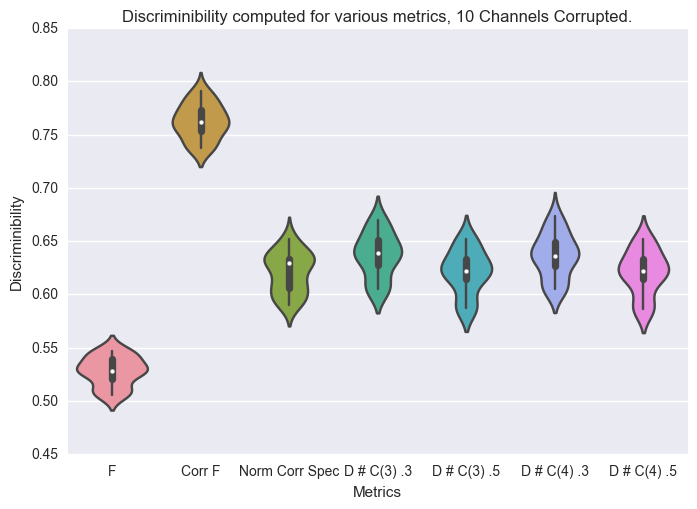

In [8]:
params = {
    'n_to_corrupt': param_map['n_to_corrupt'][0],
    'sigma': param_map['sigma'][0],
    'mu': param_map['mu'][0],
    'bad_chans': np.random.choice(128, param_map['n_to_corrupt'][0], replace=False)
}

bad_idx_10 = params['bad_chans']
D_10_corrupted = [corrupt(d, params) for d in D]
title = 'Discriminibility computed for various metrics, 10 Channels Corrupted.'
results_10 = auto_bench.metric_benchmark(D_10_corrupted, L, transforms, metrics, names, title)

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


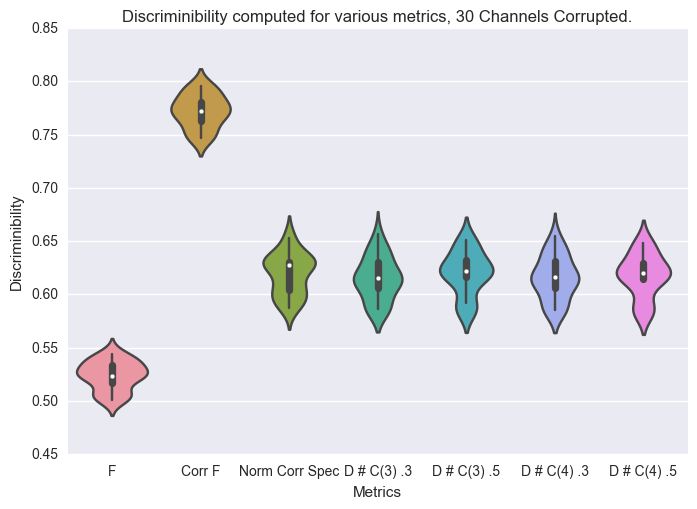

In [9]:
params = {
    'n_to_corrupt': param_map['n_to_corrupt'][2],
    'sigma': param_map['sigma'][0],
    'mu': param_map['mu'][0],
    'bad_chans': np.random.choice(128, param_map['n_to_corrupt'][2], replace=False)
}

bad_idx_30 = params['bad_chans']

D_30_corrupted= [corrupt(d, params) for d in D]
title = 'Discriminibility computed for various metrics, 30 Channels Corrupted.'
results_30 = auto_bench.metric_benchmark(D_30_corrupted, L, transforms, metrics, names, title)

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


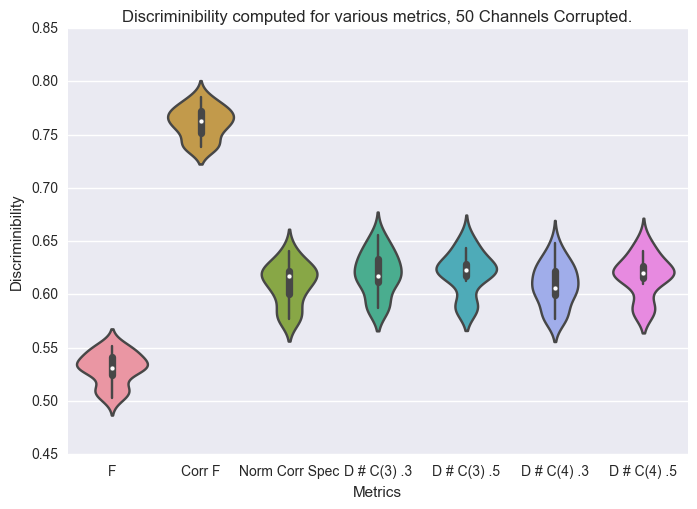

In [11]:
params = {
    'n_to_corrupt': param_map['n_to_corrupt'][4],
    'sigma': param_map['sigma'][0],
    'mu': param_map['mu'][0],
    'bad_chans': np.random.choice(128, param_map['n_to_corrupt'][4], replace=False)
}

bad_idx_50 = params['bad_chans']

D_50_corrupted = [corrupt(d, params) for d in D]
title = 'Discriminibility computed for various metrics, 50 Channels Corrupted.'
results_50 = auto_bench.metric_benchmark(D_50_corrupted, L, transforms, metrics, names, title)

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


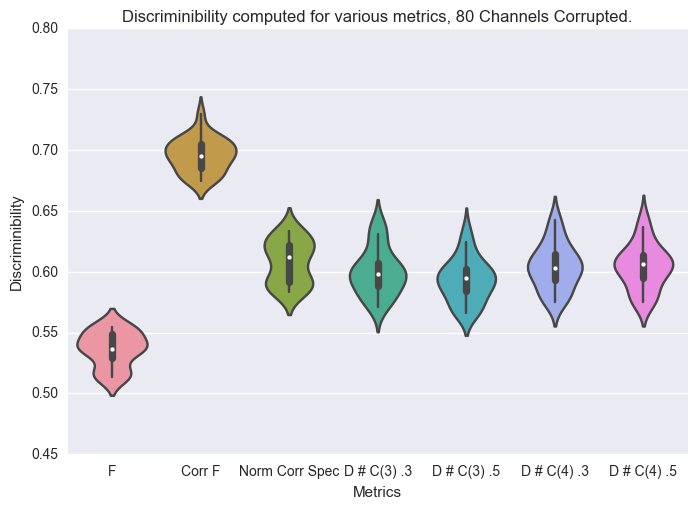

In [16]:
params = {
    'n_to_corrupt': param_map['n_to_corrupt'][7],
    'sigma': param_map['sigma'][0],
    'mu': param_map['mu'][0],
    'bad_chans': np.random.choice(128, param_map['n_to_corrupt'][7], replace=False)
}

bad_idx_80 = params['bad_chans']

D_80_corrupted = [corrupt(d, params) for d in D]
title = 'Discriminibility computed for various metrics, 80 Channels Corrupted.'
results_80 = auto_bench.metric_benchmark(D_80_corrupted, L, transforms, metrics, names, title)

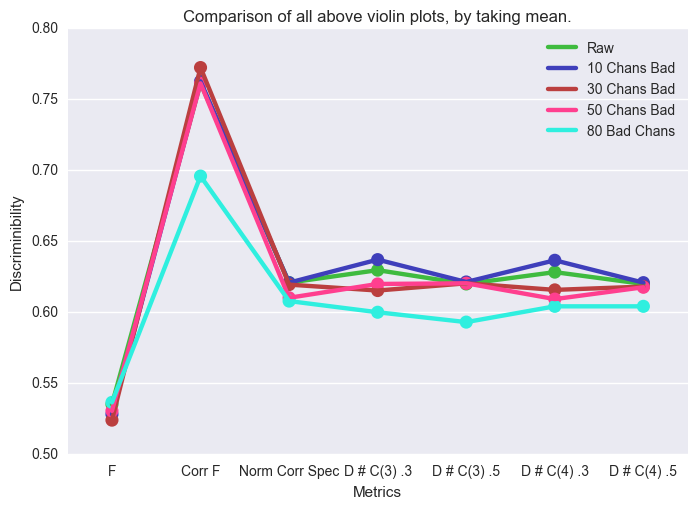

In [17]:
import matplotlib.pyplot as plt
sns.pointplot(data=(results_raw), ci=None, color="#3fbb3f", linestyles='-')
sns.pointplot(data=(results_10), ci=None, color="#3f3fbb", linestyles='-')
sns.pointplot(data=(results_30), ci=None, color="#bb3f3f", linestyles='-')
sns.pointplot(data=(results_50), ci=None, color="#ff3f8f", linestyles='-')
ax = sns.pointplot(data=(results_80), ci=None, color="#2fefdf", linestyles='-')
plt.ylabel('Discriminibility')
plt.xlabel('Metrics')
plt.title('Comparison of all above violin plots, by taking mean.')
plt.legend(['Raw', '10 Chans Bad', '30 Chans Bad', '50 Chans Bad', '80 Bad Chans'])
plt.setp(ax.collections, sizes=[50])
plt.show()

### Discussion of this 'Simulation'
It appears that the Corr Frob norm works well for this data. This is likely because the different 'trials' taken all have different tasks involved, so the most discriminible measure will likely be of some sort of average or background connectivity.

Also, it appears that the 80 Bad Channels measure actually performs quite well on the graph theoretic metrics, as well as the Norm Corr Spec metric. This is not desirable, so it may be that these metrics should not be used. Some more testing should be done, since this may just be an effect of the gaussian noise added.

### Trying to Interpolate back the noise
Here, we will use our previously developed interpolation methods to attempt to get back some of the data lost due to noise in the previous corruptions.

### Code for Spherical Splines Interpolation

In [18]:
def ssi_wrapper(D, params):
    coords = params['coords']
    rm_idx = params['bad_idx']
    s_val = params['s']
    return intp(D, coords, rm_idx, s = s_val) 

def intp(D, coords, rm_idx, s=1000):
    old = D[rm_idx, :]
    samp_idx = np.setdiff1d(np.arange(D.shape[0]), rm_idx)
    sample = D[samp_idx]
    F = []
    for i in range(sample.shape[1]):
        F_i = ssi(sample[:, i],
                  coords[samp_idx],
                  s = s)
        F.append(F_i)
    pred = []
    for idx in rm_idx:
        itp = []
        for i, f in enumerate(F):
            if f is None:
                itp.append(D[idx, i])
            else:
                itp.append(f(coords[idx, 0],
                          coords[idx, 1])[0][0])
        pred.append(np.array(itp))
    D[rm_idx] = np.array(pred)
    return D


from scipy.interpolate import SmoothSphereBivariateSpline
def ssi(E, P, s):
    try:
        F = SmoothSphereBivariateSpline(P[:, 0], P[:, 1],
                                    E, s=s)
    except:
        F = None
    return F

### Load Channel Locations

In [19]:
chan_locs = np.array(pd.read_csv('../data/chan_locs.txt',
                        sep='\t',
                        names = ['name', 't', 'p', 'r']).iloc[3:-1].as_matrix()[:, 1:])

#### 10 channels corrupted, interpolated back.

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


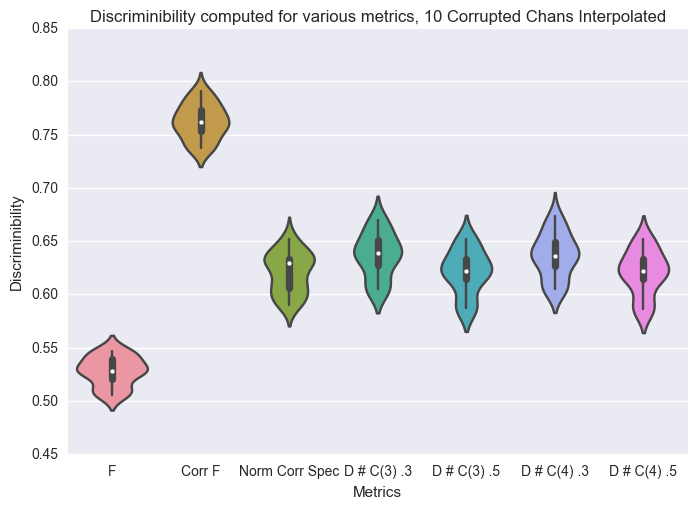

In [20]:
params = {
    's': 220000,
    'coords': chan_locs,
    'bad_idx': bad_idx_10
}

D_interp_10 = [ssi_wrapper(d, params) for d in D_10_corrupted]
title = 'Discriminibility computed for various metrics, 10 Corrupted Chans Interpolated'
results_interp_10 = auto_bench.metric_benchmark(D_interp_10,
                                                L, transforms, metrics, names, title)

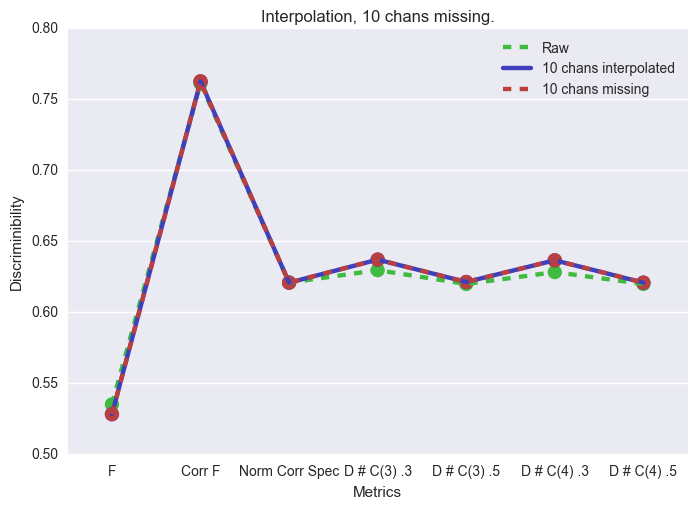

In [22]:
sns.pointplot(data=(results_raw), ci=None, color="#3fbb3f", linestyles='--')
sns.pointplot(data=(results_interp_10), ci=None, color="#3f3fbb", linestyles='-')
sns.pointplot(data=(results_10), ci=None, color="#bb3f3f", linestyles='--')
plt.ylabel('Discriminibility')
plt.xlabel('Metrics')
plt.title('Interpolation, 10 chans missing.')
plt.legend(['Raw', '10 chans interpolated', '10 chans missing'])
plt.setp(ax.collections, sizes=[50], alpha=.5)
plt.show()

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


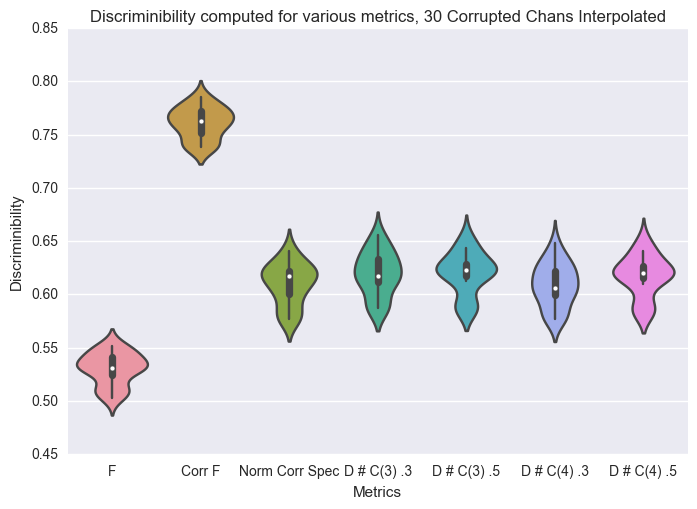

In [25]:
params = {
    's': 220000,
    'coords': chan_locs,
    'bad_idx': bad_idx_30
}

D_interp_30 = [ssi_wrapper(d, params) for d in D_50_corrupted]
title = 'Discriminibility computed for various metrics, 30 Corrupted Chans Interpolated'
results_interp_30 = auto_bench.metric_benchmark(D_interp_30,
                                                L, transforms, metrics, names, title)

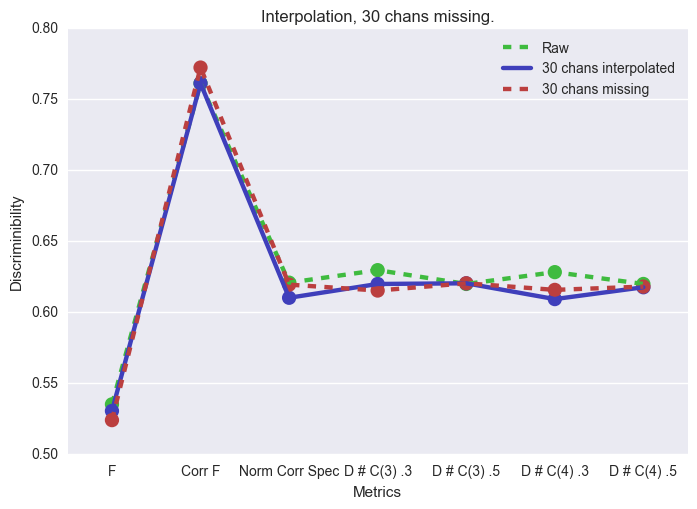

In [26]:
sns.pointplot(data=(results_raw), ci=None, color="#3fbb3f", linestyles='--')
sns.pointplot(data=(results_interp_30), ci=None, color="#3f3fbb", linestyles='-')
sns.pointplot(data=(results_30), ci=None, color="#bb3f3f", linestyles='--')
plt.ylabel('Discriminibility')
plt.xlabel('Metrics')
plt.title('Interpolation, 30 chans missing.')
plt.legend(['Raw', '30 chans interpolated', '30 chans missing'])
plt.setp(ax.collections, sizes=[50], alpha=.5)
plt.show()

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


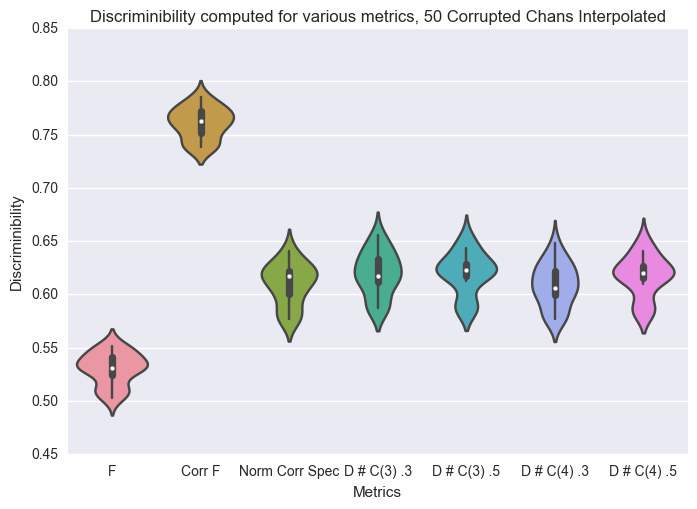

In [30]:
params = {
    's': 220000,
    'coords': chan_locs,
    'bad_idx': bad_idx_50
}

D_interp_50 = [ssi_wrapper(d, params) for d in D_50_corrupted]
title = 'Discriminibility computed for various metrics, 50 Corrupted Chans Interpolated'
results_interp_50 = auto_bench.metric_benchmark(D_interp_50,
                                                L, transforms, metrics, names, title)

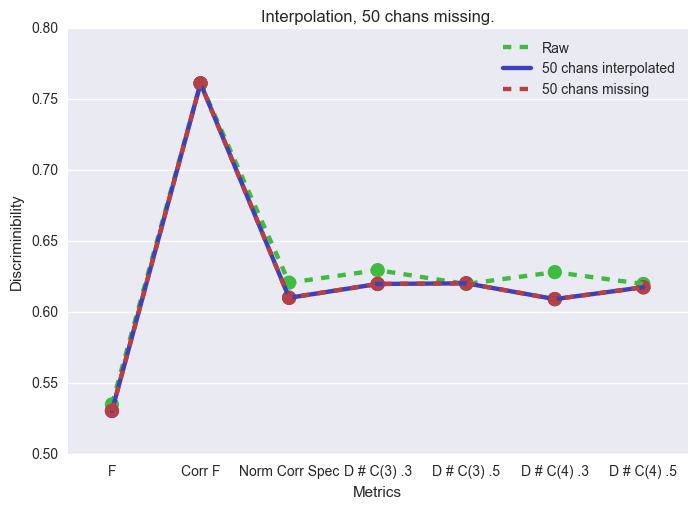

In [33]:
sns.pointplot(data=(results_raw), ci=None, color="#3fbb3f", linestyles='--')
sns.pointplot(data=(results_interp_50), ci=None, color="#3f3fbb", linestyles='-')
sns.pointplot(data=(results_50), ci=None, color="#bb3f3f", linestyles='--')
plt.ylabel('Discriminibility')
plt.xlabel('Metrics')
plt.title('Interpolation, 50 chans missing.')
plt.legend(['Raw', '50 chans interpolated', '50 chans missing'])
plt.setp(ax.collections, sizes=[50], alpha=.5)
plt.show()

F
Corr F
Norm Corr Spec
D # C(3) .3
D # C(3) .5
D # C(4) .3
D # C(4) .5


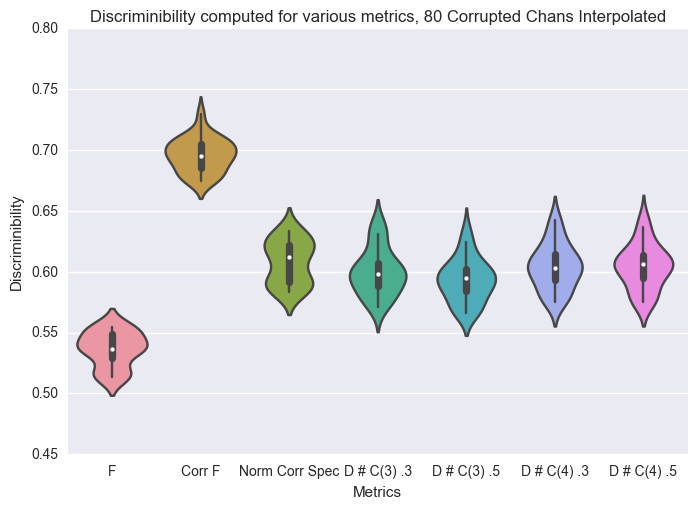

In [29]:
params = {
    's': 220000,
    'coords': chan_locs,
    'bad_idx': bad_idx_80
}

D_interp_80 = [ssi_wrapper(d, params) for d in D_80_corrupted]
title = 'Discriminibility computed for various metrics, 80 Corrupted Chans Interpolated'
results_interp_80 = auto_bench.metric_benchmark(D_interp_80,
                                                L, transforms, metrics, names, title)

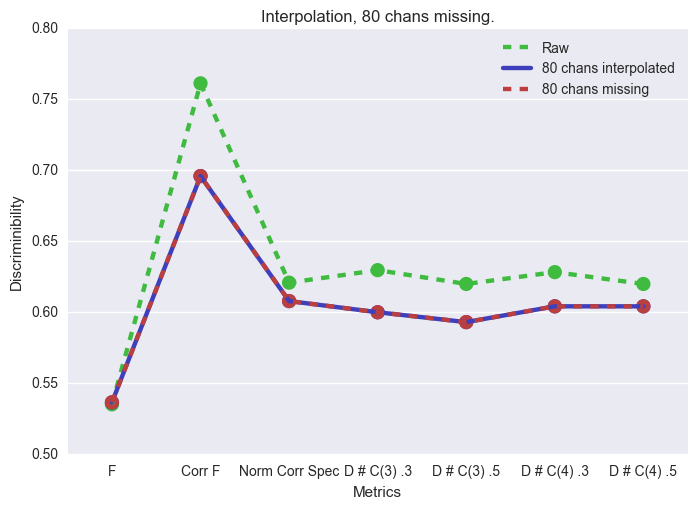

In [32]:
sns.pointplot(data=(results_raw), ci=None, color="#3fbb3f", linestyles='--')
sns.pointplot(data=(results_interp_80), ci=None, color="#3f3fbb", linestyles='-')
sns.pointplot(data=(results_80), ci=None, color="#bb3f3f", linestyles='--')
plt.ylabel('Discriminibility')
plt.xlabel('Metrics')
plt.title('Interpolation, 80 chans missing.')
plt.legend(['Raw', '80 chans interpolated', '80 chans missing'])
plt.setp(ax.collections, sizes=[50], alpha=.5)
plt.show()